In [3]:
#%matplotlib notebook
#%matplotlib auto

from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
#from galpy.potential import FerrersPotential,DehnenBarPotential
import matplotlib.pyplot as plt
#import gala.integrate as gi
#import gala.dynamics as gd
#import gala.potential as gp
#from gala.units import galactic
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial

from scipy.fft import *
from scipy import interpolate, optimize
from astropy.io import fits
from astropy.table import Table


In [2]:
# initial definitions and functions
#ft=2.*np.pi*1000*3.086*10.**(13.)/(31556926*10.**(9.))
ft=(1*u.km/u.second/u.kpc).to(1./u.Gyr).value

from galpy.potential import  omegac, epifreq
def OmegaMinusKappa(pot,Rs,n,m,ro=8.,vo=240.):
   # ro,vo for physical units, Rs in units of ro
    return omegac(pot,Rs/ro,ro=ro,vo=vo)-n/m*epifreq(pot,Rs/ro,ro=ro,vo=vo)

def F2(data,x):
    p,ro,vo,t,phi0m,phi=data[0],data[1],data[2],data[3],data[4],data[5]
    omegakappa2=OmegaMinusKappa(p,x,1,2)
    return phi-phi0m-(omegakappa2)*t/ft


# read pickle of orbits

In [153]:
# to read different simulations, change namep and nameic

ro=8.
vo=240.

namep='log' 
#namep='log_2perturb'
p=LogarithmicHaloPotential(ro=8.*u.kpc,vo=240.*u.km/u.s)
#namep='MW'#p=MWPotential2014
#namep='pn_10'
#p=PowerSphericalPotential(amp=0.1, alpha=2.2, normalize=True, r1=1.0,ro=8.,vo=240.)#decreasing
#namep='pn10'
#p=PowerSphericalPotential(amp=0.1, alpha=1.8, normalize=True, r1=1.0,ro=8.,vo=240.)#raising

nameic='circularRphi'
nameic='circularXY'
nameic='DdiscreteR'
nameic='Dhot'
#nameic='Dmedium'
#nameic='Dcold'
#nameic='Dhotn10'
#nameic='Dhotn_10'
#nameic='Dcold_log'


file='o_galpy/o_'+nameic+'.pkl'
#with open('o_galpy/o_'+nameic+'_'+namep+'.pkl', 'rb') as f:
with open('o_galpy/o_'+nameic+'_'+namep+'.pkl', 'rb') as f:#for orbits after perturbation
    o = pickle.load(f)

#o = fits.open('o_galpy/SoS_SH_Gaia_test_GAL6D.fits')
#print(o.x)

(4, 3)


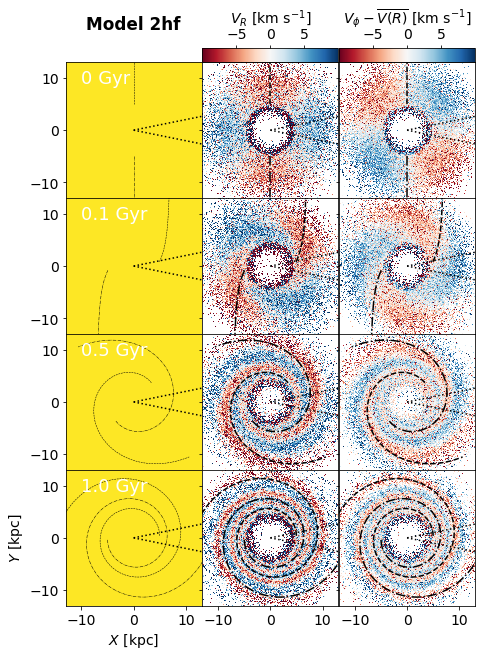

In [21]:
times=[0,0.1,0.3,0.5,1,1.5,3]
times=[0,0.1,0.5,1.]
plt.rcParams['font.size'] = 14

nrows=len(times)
ncols=3
fig = plt.figure(constrained_layout=False,figsize=(ncols*2.45,nrows*2.5))
gs = fig.add_gridspec(nrows,ncols, hspace=0., wspace=0.)
ax = gs.subplots(sharex=True,sharey=True)
print(np.shape(ax))
    
for time,i in zip(times,range(len(times))):
    
    t=time*u.Gyr
    x=o.x(t)
    y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
    VR=o.vr(t)
    Vphi=o.vphi(t)*o.r(t)
    R=o.r(t)
    Lz=R*Vphi
    phi=o.phi(t)
    
    
    #example selection in phi
    #indphi=(np.abs(phi)>np.pi-0.2)&(np.abs(phi)<np.pi+0.2)
    #x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]

    bins=100
    Xmax=15.
    DX=0.1
    binsX=np.arange(-1.*Xmax,Xmax+DX,DX)
    binsY=binsX
    Rmax=18.
    binsR=np.arange(0.,Rmax+DX,DX)
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(x,y, VR, statistic='mean', bins=[binsX,binsY])    
    mVphi,xedge,yedge,binnumber=stats.binned_statistic_2d(x,y, Vphi, statistic='mean', bins=[binsX,binsY])

    #fractional change in Vphi with respect to average in that radius
    binsR=np.arange(0.,Rmax+DX,DX)
    m2,redges0,binnumber=stats.binned_statistic(R,Vphi,bins=[binsR], statistic='mean')
    rcenter0= redges0[1:] - DX/2.
    for ii in range(len(xedge)-1):
        for jj in range(len(yedge)-1):
            rr=np.sqrt((xedge[ii].T)**2.+(yedge[jj])**2.)
            idx = (np.abs(rcenter0 - rr)).argmin()
            mVphi[ii,jj]=(mVphi[ii,jj]-m2[idx])
            
    DX=0.5
    DX=0.3
    DX=1.
    Rmax=20
    binsX=np.arange(-1.*Xmax,Xmax+DX,DX)
    binsR=np.arange(0.,Rmax+DX,DX)
    binsY=binsX
    #ax[i,0].hist2d(x,y, bins=[binsX,binsY])
    #h0,xedges,yedges=np.histogram2d(x,y,bins=[binsX,binsY])#,weights=weights) 
    #print(weights)
    #print(max(h0.flatten()))
    #hist, bin_edges = np.histogram(R,bins=binsR,density=True)
    #norm=1./np.log(hist)
    #indw=np.digitize(R,bins=binsR)-1
    #weights=norm[indw]
    h0,xedges,yedges=np.histogram2d(x,y,bins=[binsX,binsY])#,weights=weights) 
    #print(max(h0.flatten()))
    #print('   stop.  ')
    #h5=gaussian_filter(h0, 1)#, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)[source]¶
    #h10=gaussian_filter(h0, 4)#, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)[source]¶
    #h=h0-h10
    #h=h0/h5-1. 
    #h=h5/h10-1. 
    #im0=ax[i,0].pcolormesh(xedges, yedges, h0.T, norm=mcolors.LogNorm(1,1000))#,norm=mcolors.PowerNorm(0.6)
    ax[i,0].hist2d(x,y, bins=100)

    
    #ax[i,0].scatter(x,y,s=0.01)
    #ax[i,0].set_title(str(time))
    ax[i,0].text(-10., 9, str(time)+' Gyr',color='white',fontsize=18.)


    im1 = ax[i,1].pcolormesh(xedge,yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)#,norm=mcolors.PowerNorm(nn), cmap=mycolormap)

    im2 = ax[i,2].pcolormesh(xedge,yedge, mVphi.T, cmap='RdBu',vmin=-10,vmax=10)#,norm=mcolors.PowerNorm(nn), cmap=mycolormap)
    
    for jj in range(3):
        ax[i,jj].set_xlim(-13,13)
        ax[i,jj].set_ylim(-13,13)
        ax[i,jj].set_aspect('equal')
    ax[len(times)-1,0].set_xlabel('$X$ [kpc]')
    ax[len(times)-1,0].set_ylabel('$Y$ [kpc]')

    ax[0,0].set_title('Model 2hf', y=1.2,fontweight='bold')
    #ind=abs(phi)<0.3
    #h,xe,ye,im=ax[i,3].hist2d(R[ind],Vphi[ind], bins=bins)
    #ax[i,3].set_xlim(4.5,14)
    #ax[i,3].set_ylim(195,205)
        
    rr=np.arange(5.,15,0.05)
    omegakappa2=OmegaMinusKappa(p,rr,1,2)
    phim0=-np.pi/2.
    phimwrap=(omegakappa2)*time/ft+phim0
    #phimwrap=(phimwrap+ np.pi) % (2 * np.pi) - np.pi
    xx=rr*np.cos(phimwrap)
    yy=-rr*np.sin(phimwrap)
    
    #ax[i,1].plot(phim,r,'o',c='k')
    #ax[i,0].plot(xx,yy,'o',c='k',markersize=3)
    #ax[i,1].plot(xx,yy,'o',c='k',markersize=3)
    #ax[i,2].plot(xx,yy,'o',c='k',markersize=3)
    #ax[i,0].plot(-xx,-yy,'o',c='grey',markersize=3)
    #ax[i,1].plot(-xx,-yy,'o',c='grey',markersize=3)
    #ax[i,2].plot(-xx,-yy,'o',c='grey',markersize=3)
    c1='pink'
    c2='cyan'
    c1='k'
    c2='grey'
    c2='k'
    ls1='--'
    ls2='--'
    ls2=(0,(1,10))
    ls2='dashdot'
    ax[i,0].plot(xx,yy,c=c1,linestyle=ls1,linewidth=0.5)
    ax[i,1].plot(xx,yy,c=c1,linestyle=ls1)
    ax[i,2].plot(xx,yy,c=c1,linestyle=ls1)
    
    ax[i,0].plot(-xx,-yy,c=c2,linestyle=ls2,linewidth=0.5)
    ax[i,1].plot(-xx,-yy,c=c2,linestyle=ls2)
    ax[i,2].plot(-xx,-yy,c=c2,linestyle=ls2)
    
    phi1=np.pi-0.2
    phi2=np.pi+0.2
    R1=np.arange(0,20,1)
    X1=-R1*np.cos(phi1)
    Y1=-R1*np.sin(phi1)
    X2=-R1*np.cos(phi2)
    Y2=-R1*np.sin(phi2)
    c3='grey'
    ls3=':'
    
    for jj in range(3):
        ax[i,jj].plot(X1,Y1,c=c2,linestyle=ls3)
        ax[i,jj].plot(X2,Y2,c=c2,linestyle=ls3)



plt.draw()
p0 = ax[0,0].get_position().get_points().flatten()
p1 = ax[0,1].get_position().get_points().flatten()
p2 = ax[0,2].get_position().get_points().flatten()
#ax_cbar = fig.add_axes([p0[0], 0, p1[2]-p0[0], 0.05])
#plt.colorbar(sc1, cax=ax_cbar, orientation='horizontal')
#[left, bottom, width, height]
ax_cbar1 = fig.add_axes([p1[0], p2[3], p1[2]-p1[0], 0.02])
cb1=plt.colorbar(im1, cax=ax_cbar1, orientation='horizontal') 
cb1.ax.xaxis.set_ticks_position("top")
cb1.ax.xaxis.set_label_position('top')   
cb1.set_label(r'$V_R$ [km s$^{-1}$]')
cb1.ax.xaxis.set_ticks([-5,0,5])
ax_cbar2 = fig.add_axes([p2[0], p2[3], p2[2]-p2[0], 0.02])
cb2=plt.colorbar(im2, cax=ax_cbar2, orientation='horizontal')        
cb2.ax.xaxis.set_ticks_position("top")
cb2.ax.xaxis.set_label_position('top')   
cb2.ax.xaxis.set_ticks([-5,0,5])
cb2.set_label(r'$V_\phi-\overline{V(R)}$ [km s$^{-1}$]')

namef='plots/xymodel'+nameic+namep+'.png'
plt.savefig(namef, bbox_inches='tight')
    

In [317]:
class Loader():
    o_cache = None
    o_cache_name = None
    oo = None

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2):
        if self.o_cache_name == model:
            o = self.o_cache
        else:
            file='o_galpy/o_'+model+'.pkl'
            with open(file, 'rb') as f:#for orbits after perturbation
                o = pickle.load(f)
            self.o_cache = o
            self.o_cache_name = model

        t=time*u.Gyr
        x=o.x(t)
        y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
        VR=o.vr(t)
        Vphi=o.vphi(t)*o.r(t)
        R=o.r(t)
        Lz=R*Vphi
        phi=o.phi(t)

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(np.abs(VR)<20)&(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]

        return x,y,VR,Vphi,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4):
        if self.oo == None:
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo

        VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        return x,y,VR,Vphi,R,Lz,phi

def smooth_bins(x, y, xmin, xmax, binsize):
    m,xedge,binnumber=stats.binned_statistic(Lz,VR, statistic='mean', bins=[binsLZ]) 
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            means.append(means[-1])
        else:
            means.append(np.mean(rel))
    ypol = np.array(means)
    return xpol, ypol

l = Loader()
CURMODEL = 'Dhot_log'
#CURMODEL = 'Dhot_log_2perturb'
#CURMODEL = 'Dhotn10_pn10'
#CURMODEL = 'Dhotn_10_pn_10'


/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



(-20.0, 20.0)

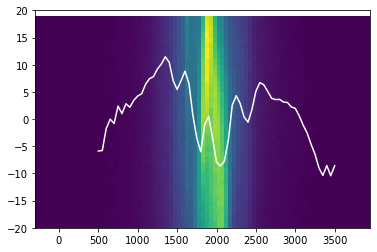

In [252]:
#TIME = 2.15
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)

XMIN=500
XMAX=3500
BINSIZE = 50
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

xpol, ypol = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = len(xpol)

#yf = fft(ypol)
#xf = fftfreq(N, T)
#yf = yf
#yf[abs(yf) < 1000] = 0
#yf[abs(xf) > 0.1] = 0
#print(sum(yf!=0))
##plt.plot(xf, 2.0/N * np.abs(yf))
#
#
#plt.hist2d(Lz, VR, bins=100);
#plt.plot(xpol, ifft(yf), color='w')

#plt.hist2d(Lz, AR, bins=100);
#plt.ylim(-1,1)
binsLZ=np.arange(-300,4000,50)
binsVR=np.arange(-20,20,1)
plt.hist2d(Lz, VR, bins=[binsLZ, binsVR]);
plt.plot(xpol, ypol, c='white')
plt.ylim(-20,20)

In [6]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

TIME = 2.05
BIAS = -840

t=TIME*u.Gyr
x=o.x(t)
y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
VR=o.vr(t)
Vphi=o.vphi(t)*o.r(t)
R=o.r(t)
Lz=R*Vphi
phi=o.phi(t)

EPS = 0.001 * u.Gyr
AR = (VR - o.vr(t-EPS))

indphi=(np.abs(phi)>np.pi-0.2)&(np.abs(phi)<np.pi+0.2)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]
indphi=(np.abs(VR)<20)&(np.abs(Lz)>1000)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]
KNN = 100

VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
Lz=-oo['Vphi']*oo['R']
phi=-np.deg2rad(phi)
Vphi=-Vphi

PHI_RANGE = 0.4
indphi = abs(phi) < PHI_RANGE
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
indphi=(np.abs(VR)<20)&(Lz>1500)&(Lz<2500)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
KNN = 2000

si = np.argsort(Lz)
sx = Lz[si]
sy = VR[si]
kernel_size = KNN
kernel = np.ones(kernel_size) / kernel_size
nx = np.convolve(sx, kernel, mode='valid')
ny = np.convolve(sy, kernel, mode='valid')

N = 100000
P = 1
ny = ny / nx
nx = np.log(nx+BIAS)**P
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
print(nx[0], nx[-1])
ypol = f(xpol)

#roots = []
#for x0 in np.linspace(nx[100], nx[-100], 100):
#    try:
#        root = optimize.fsolve(f, x0)[0]
#        if not (abs(roots-root) < 50).any():
#            roots.append(root)
#        else:
#            pass
#            ind = np.argmax((abs(roots-root) < 50))
#            if (abs(f(roots[ind])) > abs(f(root))):
#                roots[ind] = root
#    except:
#        pass
#a = abs(f(roots)) < 1
#roots = np.array(roots)[a]
#roots.sort()
#roots = np.log(roots)
#
#plt.plot(np.arange(0,len(roots)), roots)
#plt.plot((0,len(roots)-1), (roots[0], roots[-1]))


NameError: name 'o' is not defined

3.424881636631067
0.08685791358637798
[4.70073494e+03 2.08435570e+03 1.35814630e+03 ... 8.00038951e-02
 8.00022949e-02 8.00006948e-02]
400.6624514962132


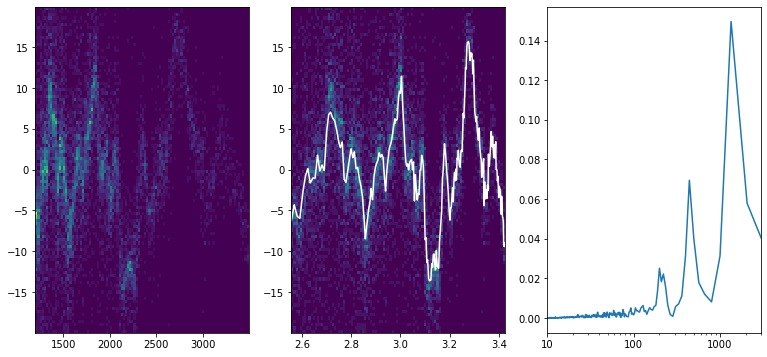

In [312]:

BIAS = -840

TIME = 1.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)

#XMIN=1000
#XMAX=3000
#BINSIZE = 50
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
nxo = nx
nyo = ny
ny = ny
nx = np.log10(nx+BIAS)**P
f = interpolate.interp1d(nx, ny, kind='linear')
print(nx[-1])
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)

fig, ax = plt.subplots(1,3,figsize=(13,6))
#ypol = 5*np.sin(0.02*xpol)
#ax[0].hist2d(np.log10(Lz)**P, VR/Lz, bins=100);
#ax[0].plot(xpol, ypol, c='white')
#ax[0].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
ax[0].hist2d(Lz, VR, bins=100);
ax[0].plot(xpol, ypol, c='white')
ax[1].hist2d(np.log10(Lz+BIAS), VR, bins=100);
ax[1].plot(xpol, ypol, c='white')
#ax[0].set_ylim(min(ypol), max(ypol))

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]
print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))

CUT = 3
xfr = ((nx[-1]-nx[0]) / abs(xf * N))
avglz = (nx[-1] - nx[0])/2
avglz = np.log10((XMIN + XMAX)/2)
avglz = np.log10(2000)
xfr = (10**(avglz+xfr/2) - 10**(avglz-xfr/2))
print(xfr)
ax[2].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
print(xfr[yf.argmax()])
#ax[1].plot(xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1], np.abs(yf)[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]/np.sum(np.abs(yf)))
#ax[1].set_xlim(1e-2, 2.0)
ax[2].set_xlim(10, 3000)
ax[2].set_xscale('log')
ax[2].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[2].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
#plt.ylim(0, 1)
#plt.show()
#
#CUT = 1
yf2 = np.copy(yf)
yf2[0:abs(yf).argmax()+CUT+1] = 0
#ax[1].plot(xfr, np.abs(yf2)/np.sum(np.abs(yf)))
#ax[0].plot(xpol[1:], ifft(yf)/20, color='y')

3.424881636631067
0.08685791358637798
[4.70073494e+03 2.08435570e+03 1.35814630e+03 ... 8.00038951e-02
 8.00022949e-02 8.00006948e-02]
400.6624514962132


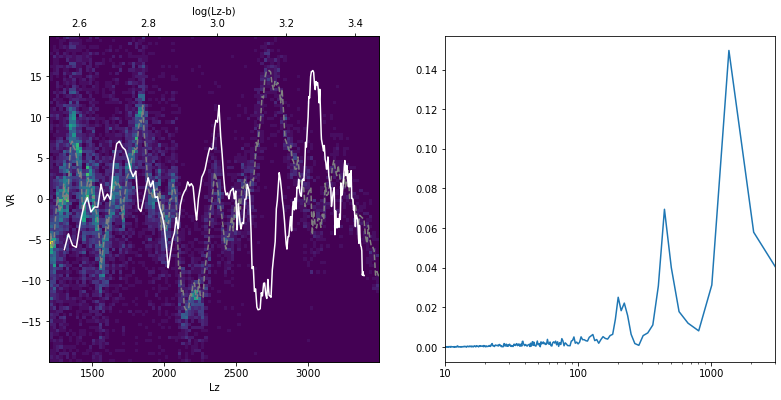

In [315]:
BIAS = -840

TIME = 1.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)

#XMIN=1000
#XMAX=3000
#BINSIZE = 50
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
ny = ny
nx = np.log10(nx+BIAS)**P
f = interpolate.interp1d(nx, ny, kind='linear')
print(nx[-1])
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)

fig, ax = plt.subplots(1,2,figsize=(13,6))
#ypol = 5*np.sin(0.02*xpol)
#ax[0].hist2d(np.log10(Lz)**P, VR/Lz, bins=100);
#ax[0].plot(xpol, ypol, c='white')
#ax[0].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
ax[0].hist2d(Lz, VR, bins=100);
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('VR')
ax[0].plot(*smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE), c='grey', ls='--')
#ax[1].hist2d(np.log10(Lz+BIAS), VR/Lz, bins=100);
ax_right = ax[0].twiny()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_xlabel('log(Lz-b)')
#ax[0].set_ylim(min(ypol), max(ypol))

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]
print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))

CUT = 3
xfr = ((nx[-1]-nx[0]) / abs(xf * N))
avglz = (nx[-1] - nx[0])/2
avglz = np.log10((XMIN + XMAX)/2)
avglz = np.log10(2000)
xfr = (10**(avglz+xfr/2) - 10**(avglz-xfr/2))
print(xfr)
ax[1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
print(xfr[yf.argmax()])
#ax[1].plot(xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1], np.abs(yf)[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]/np.sum(np.abs(yf)))
#ax[1].set_xlim(1e-2, 2.0)
ax[1].set_xlim(10, 3000)
ax[1].set_xscale('log')
ax[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
#plt.ylim(0, 1)
#plt.show()
#
#CUT = 1
yf2 = np.copy(yf)
yf2[0:abs(yf).argmax()+CUT+1] = 0
#ax[1].plot(xfr, np.abs(yf2)/np.sum(np.abs(yf)))
#ax[0].plot(xpol[1:], ifft(yf)/20, color='y')

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

3000.0
2000.0
3.4771212547196626
0.4771212547196626
3.3344537511509307
0.5651668842475028


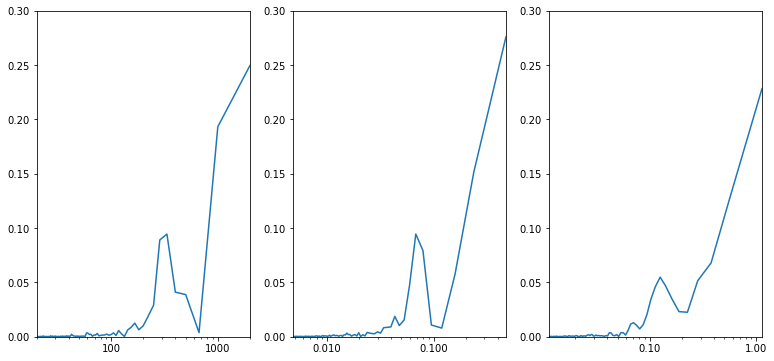

In [304]:
BIAS = -840

TIME = 1.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)

XMIN=1000
XMAX=3000
BINSIZE = 50
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
nxs = [nx, np.log10(nx), np.log10(nx+BIAS)]
nx_names = ["Lz", "log(Lz)", "log(Lz+bias)"]
fig, ax = plt.subplots(1,3,figsize=(13,6))
for nxi, nx in enumerate(nxs):
    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    print(nx[-1])
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]

    CUT = 3
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    #avglz = (nx[-1] - nx[0])/2
    #avglz = np.log10((XMIN + XMAX)/2)
    #avglz = np.log10(2000)
    #xfr = (10**(avglz+xfr/2) - 10**(avglz-xfr/2))
    ax[nxi].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
    print(xfr[yf.argmax()])
    #ax[1].plot(xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1], np.abs(yf)[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]/np.sum(np.abs(yf)))
    #ax[1].set_xlim(1e-2, 2.0)
    ax[nxi].set_xlim(min(xfr[:100]), max(xfr))
    ax[nxi].set_ylim(0, 0.3)
    ax[nxi].set_xscale('log')
    ax[nxi].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[nxi].set_aspect('auto')
    #ax[nxi].set_title(nx_names[i])


-755.1020408163265


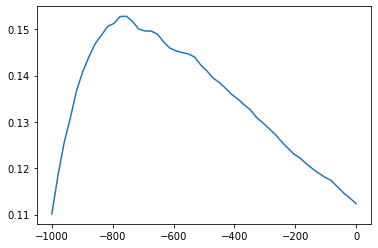

In [298]:
#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')


TIME = 1.4
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)

#XMIN=1500
#XMAX=2300
#BINSIZE = 1
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

biases = np.linspace(-1000, 0, 50)
peaks = []
for bias in biases:
    nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
    N = 100000
    P = 1
    ny = ny
    nx = np.log(nx+bias)**P
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    CUT = 5
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    peaks.append(np.max(abs(yf)) / np.sum(abs(yf)))

plt.plot(biases, peaks)
print(biases[np.argmax(peaks)])

0.1 -673.469387755102
0.22083333333333333 -1000.0
0.3416666666666667 -530.6122448979593
0.4625 -632.6530612244899
0.5833333333333334 -836.7346938775511
0.7041666666666666 -714.2857142857142
0.825 -469.38775510204084
0.9458333333333333 -816.3265306122449
1.0666666666666667 -734.6938775510205
1.1875 -959.1836734693877
1.3083333333333333 -857.1428571428571
/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

1.4291666666666667 -795.9183673469388
1.55 -897.9591836734694
1.6708333333333334 -836.7346938775511
1.7916666666666667 -979.5918367346939
1.9125 -857.1428571428571
2.033333333333333 -836.7346938775511
2.154166666666667 -938.7755102040817
2.275 -877.5510204081633
2.3958333333333335 -836.7346938775511


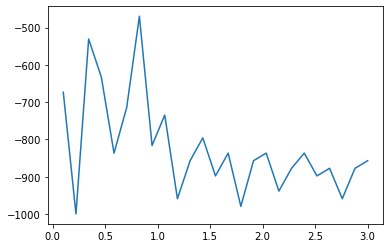

In [13]:
#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')


xtime = np.linspace(0.1, 3, 25)
ytime = []

for TIME in xtime:
    XMIN=1200
    XMAX=3500
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)

    #XMIN=1500
    #XMAX=2300
    #BINSIZE = 1
    #x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
    
    biases = np.linspace(-1000, 0, 50)
    peaks = []
    for bias in biases:
        nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
        N = 100000
        P = 1
        ny = ny / nx
        nx = np.log(nx+bias)**P
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)

        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        yf = fft(ypol)
        xf = fftfreq(N)
        yf = yf[xf>0]
        xf = xf[xf>0]
        CUT = 5
        xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        peaks.append(np.max(abs(yf)) / np.sum(abs(yf)))

    #plt.plot(biases, peaks)
    print(TIME, biases[np.argmax(peaks)])
    ytime.append(biases[np.argmax(peaks)])

plt.plot(xtime, ytime)
print(np.mean(ytime))

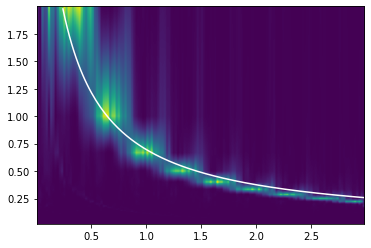

In [293]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

BIAS = -840
eps = 0.00001
times = np.arange(eps, 3.0+eps, 0.02)
vtimes = list(times)

fourier = []
freqs = []
freqs2 = []
for time in times:
    XMIN=1200
    XMAX=3500
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
    
    nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
    N = 100000
    P = 1
    ny = ny / nx
    nx = np.log(nx+BIAS)**P
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)
    
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    fourier.append(yf)
    
    CUT = 4
    relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
        vtimes.remove(time)
        continue
    freqs.append(freq)
    
    CUT = 4
    yfb = yf.copy()
    yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1] = 0
    relxfr = xfr[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    relyf = yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    freqs2.append(freq)

fourier = np.abs(np.array(fourier))
xfr = xfr[:100]
fourier = fourier[:,:100]
f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
y_coords = np.linspace(min(xfr),max(xfr),500)
Z = [fi(y_coords) for fi in f]
Z = np.array(Z).T
#plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
#f = interpolate.interp2d(times,xfr,fourier,kind="linear")
#x_coords = times
#y_coords = np.linspace(min(xfr),max(xfr),200)
#Z = f(x_coords,y_coords)
#Z = Z/Z.sum(axis=1,keepdims=1)
plt.imshow((Z/np.max(Z))**2,extent=[min(times),max(times),min(y_coords),max(y_coords)],origin="lower")

#plt.plot(vtimes, np.array(freqs), color='w')
 
fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
pol = np.poly1d(fit)
plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')

fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = r

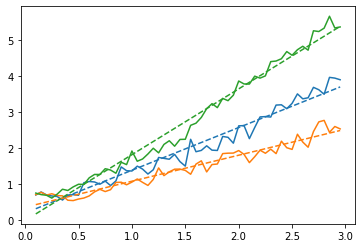

In [21]:
for model_i, model in enumerate(['Dhot_log', 'Dhotn10_pn10', 'Dhotn_10_pn_10']):
#for model_i, model in enumerate(['Dhotn_10_pn_10']):
    
    BIAS = -840
    times = np.arange(0.1, 3.0, 0.05)
    vtimes = list(times)
    freqs = []
    freqs2 = []

    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

        nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
        N = 100000
        P = 1
        ny = ny / nx
        nx = np.log(nx+BIAS)**P
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)
        
        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        yf = fft(ypol)
        xf = fftfreq(N)
        yf = yf[xf>0]
        xf = xf[xf>0]
        xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        #print(time, xfr[yf.argmax()])
        #freqs.append(xfr[yf.argmax()])
        CUT = 5
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
            vtimes.remove(time)
            continue
        freqs.append(freq)
        #if (1/freq < 2 and time > 2):
        #    print(time,1/freq)
        CUT = 0
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        freqs2.append(freq)


    #plt.plot(times, 1/np.array(freqs2))
    plt.plot(vtimes, 1/np.array(freqs), c=f'C{model_i}')

    fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    
    pol = np.poly1d(fit)
    plt.plot(times, pol(times), c=f'C{model_i}', ls='--')

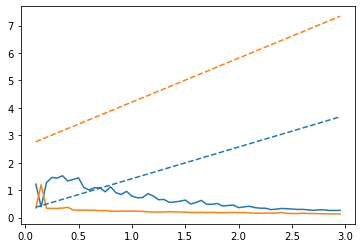

In [126]:
for model_i, model in enumerate(['Dhot_log_2perturb']):
    
    BIAS = -840
    times = np.arange(0.1, 3.0, 0.05)
    vtimes = list(times)
    freqs = []
    freqs2 = []

    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

        nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
        N = 100000
        P = 1
        ny = ny / nx
        nx = np.log(nx+BIAS)**P
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)
        
        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        yf = fft(ypol)
        xf = fftfreq(N)
        yf = yf[xf>0]
        xf = xf[xf>0]
        xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        #print(time, xfr[yf.argmax()])
        #freqs.append(xfr[yf.argmax()])
        CUT = 5
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
            vtimes.remove(time)
            continue
        freqs.append(freq)
        #if (1/freq < 2 and time > 2):
        #    print(time,1/freq)
        CUT = 4
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        yf2 = np.copy(yf)
        yf2[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1] = 0
        ax[0].plot(xfr, 2.0/N * np.abs(yf-yf2))
        ax[1].plot(xfr, 2.0/N * np.abs(yf2))
        relxfr = xfr[max(0,abs(yf2).argmax()-CUT):abs(yf2).argmax()+CUT+1]
        relyf = yf[max(0,abs(yf2).argmax()-CUT):abs(yf2).argmax()+CUT+1]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        freqs2.append(freq)


    plt.plot(vtimes, 1/np.array(freqs), c='C0')
    plt.plot(vtimes, 1/np.array(freqs2), c='C1')

    fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    pol = np.poly1d(fit)
    plt.plot(times, pol(times), c=f'C0', ls='--')
    fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
    pol = np.poly1d(fit)
    plt.plot(times, pol(times), c=f'C1', ls='--')

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

1.9999773703255894
/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

0.1999977370325589
/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value e

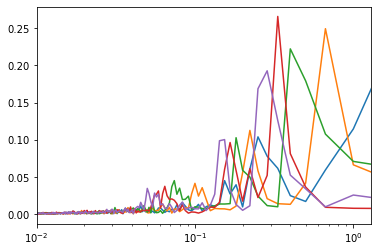

In [64]:
#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

BIAS = -840
eps = 0.01
times = np.arange(0.5, 2.5+eps, 0.5)
freqs = []
freqs2 = []

for time in times:
    XMIN=1200
    XMAX=3500
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

    #XMIN=1500
    #XMAX=2300
    #BINSIZE = 1
    #x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

    nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
    N = 100000
    P = 1
    ny = ny / nx
    nx = np.log(nx+BIAS)**P
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    
    CUT=4
    yf2 = np.copy(yf)
    yf2[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1] = 0
    
    plt.plot(xfr, 2.0/N * np.abs(yf))
    plt.xlim(1e-2, 1.3)
    plt.xscale('log')
    #plt.xaxis.set_major_formatter(ticker.ScalarFormatter())



/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

1.9999773703255894
/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

0.1999977370325589
/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value e

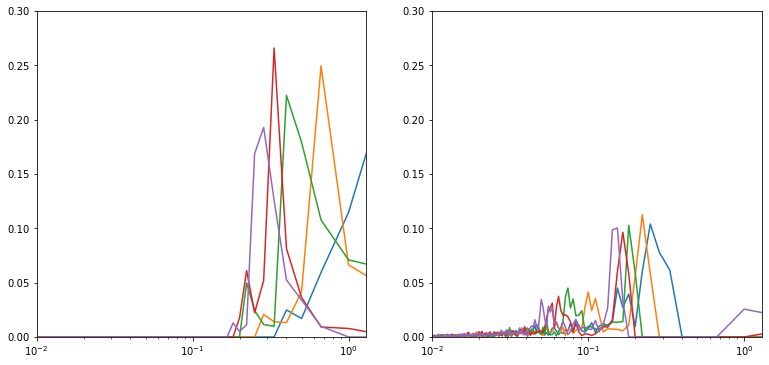

In [72]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

BIAS = -840
eps = 0.01
times = np.arange(0.5, 2.5+eps, 0.5)
freqs = []
freqs2 = []
fig, ax = plt.subplots(1,2,figsize=(13,6))

for time in times:
    XMIN=1200
    XMAX=3500
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

    #XMIN=1500
    #XMAX=2300
    #BINSIZE = 1
    #x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

    nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
    N = 100000
    P = 1
    ny = ny / nx
    nx = np.log(nx+BIAS)**P
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    
    CUT=4
    yf2 = np.copy(yf)
    yf2[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1] = 0
    
    ax[0].plot(xfr, 2.0/N * np.abs(yf-yf2))
    ax[1].plot(xfr, 2.0/N * np.abs(yf2))
    for a in ax:
        a.set_xlim(1e-2, 1.3)
        a.set_ylim(0, 0.3)
        a.set_xscale('log')
    #plt.xaxis.set_major_formatter(ticker.ScalarFormatter())


6.955515886790864 8.18721959318513
0.24634074127885325


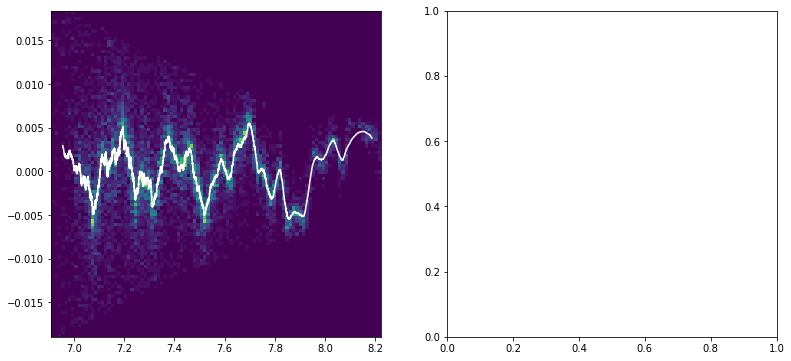

In [77]:

#N = 100000
#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

TIME =  1.2

t=TIME*u.Gyr
x=o.x(t)
y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
VR=o.vr(t)
Vphi=o.vphi(t)*o.r(t)
R=o.r(t)
Lz=R*Vphi
phi=o.phi(t)

EPS = 0.001 * u.Gyr
AR = (VR - o.vr(t-EPS))

indphi=(np.abs(phi)>np.pi-0.2)&(np.abs(phi)<np.pi+0.2)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]
indphi=(np.abs(VR)<20)&(np.abs(Lz)>1000)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]

si = np.argsort(Lz)
sx = Lz[si]
sy = VR[si]
KNN = 100
nx = []
ny = []
for i in range(len(si)-KNN):
    nx.append(np.mean(sx[i:i+KNN]))
    ny.append(np.mean(sy[i:i+KNN]))
nx = np.array(nx)
ny = np.array(ny)

N = 100000
P = 1
ny = ny / nx
nx = np.log(nx)**P
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
print(nx[0], nx[-1])
ypol = f(xpol)

fig, ax = plt.subplots(1,2,figsize=(13,6))
#ypol = 5*np.sin(0.02*xpol)
ax[0].hist2d(np.log(Lz)**P, VR/Lz, bins=100);
ax[0].plot(xpol, ypol, c='white')
ax[0].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)


ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
#yf[abs(yf) < 5000] = 0
#yf[abs(xf) > 0.0001] = 0
#print(sum(yf!=0))
print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))


1
0.0236716566440072


(0.0, 0.0003)

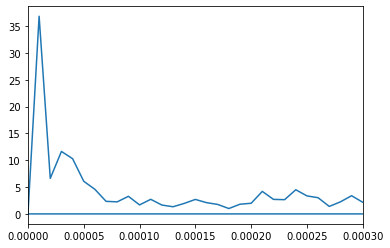

In [604]:

#N = 100000
#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

TIME = 0.1

t=TIME*u.Gyr
x=o.x(t)
y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
VR=o.vr(t)
Vphi=o.vphi(t)*o.r(t)
R=o.r(t)
Lz=R*Vphi
phi=o.phi(t)

EPS = 0.001 * u.Gyr
AR = (VR - o.vr(t-EPS))

indphi=(np.abs(phi)>np.pi-0.2)&(np.abs(phi)<np.pi+0.2)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]
indphi=(np.abs(VR)<20)&(np.abs(Lz)>1000)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]

si = np.argsort(Lz)
sx = Lz[si]
sy = VR[si]
KNN = 100
nx = []
ny = []
for i in range(len(si)-KNN):
    nx.append(np.mean(sx[i:i+KNN]))
    ny.append(np.mean(sy[i:i+KNN]))
nx = np.array(nx)
ny = np.array(ny)
ny = ny / nx # Same amplitude

px = np.linspace(0.0005,2,100)
py = []
for P in px:
    N = 100000
    nx2 = np.log(nx)**P
    f = interpolate.interp1d(nx2, ny, kind='linear')
    xpol = np.linspace(nx2[0], nx2[-1], N)
    ypol = f(xpol)
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol, norm='ortho')
    xf = fftfreq(N)
    #print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))
    py.append(abs(yf.max()))
py = np.array(py)

P = px[py.argmax()]
P = 1
print(P)

N = 100000
nx2 = np.array(nx)
f = interpolate.interp1d(nx2, ny, kind='linear')
xpol = np.linspace(nx2[0], nx2[-1], N)
ypol = f(xpol)
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol, norm='ortho')
xf = fftfreq(N)
#plt.plot(xf, abs(yf))


N = 100000
nx2 = np.log(nx)**P
f = interpolate.interp1d(nx2, ny, kind='linear')
xpol = np.linspace(nx2[0], nx2[-1], N)
ypol = f(xpol)
ymean, ymax, ymin = ypol.mean(), ypol.max(), ypol.min()
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol, norm='ortho')
xf = fftfreq(N)
print((nx2[-1]-nx2[0]) / abs(xf[yf.argmax()] * N))
plt.plot(xf, abs(yf))
#plt.xlim(0,0.0003)

#yf[abs(yf) < 5] = 0
#print(sum(yf>0))
#plt.hist2d(np.log(Lz)**P, VR/Lz, bins=100);
#plt.plot(xpol, (ifft(yf, norm='ortho')*(ymax - ymin) + ymean), c='white')

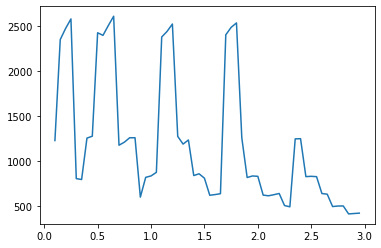

In [455]:
xtime = []
ytime = []

for time in np.arange(0.1, 3., 0.05):
    t=time*u.Gyr
    x=o.x(t)
    y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
    VR=o.vr(t)
    Vphi=o.vphi(t)*o.r(t)
    R=o.r(t)
    Lz=R*Vphi
    phi=o.phi(t)

    indphi=(np.abs(phi)>np.pi-0.2)&(np.abs(phi)<np.pi+0.2)
    x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
    indphi=(np.abs(VR)<20)&(np.abs(Lz)>1000)
    x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]

    si = np.argsort(Lz)
    sx = Lz[si]
    sy = VR[si]
    KNN = 100
    nx = []
    ny = []
    for i in range(len(si)-KNN):
        nx.append(np.mean(sx[i:i+KNN]))
        ny.append(np.mean(sy[i:i+KNN]))

    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    maxperiod = (nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N)
    
    xtime.append(time)
    ytime.append(maxperiod)

plt.plot(xtime, ytime)
plt.show()

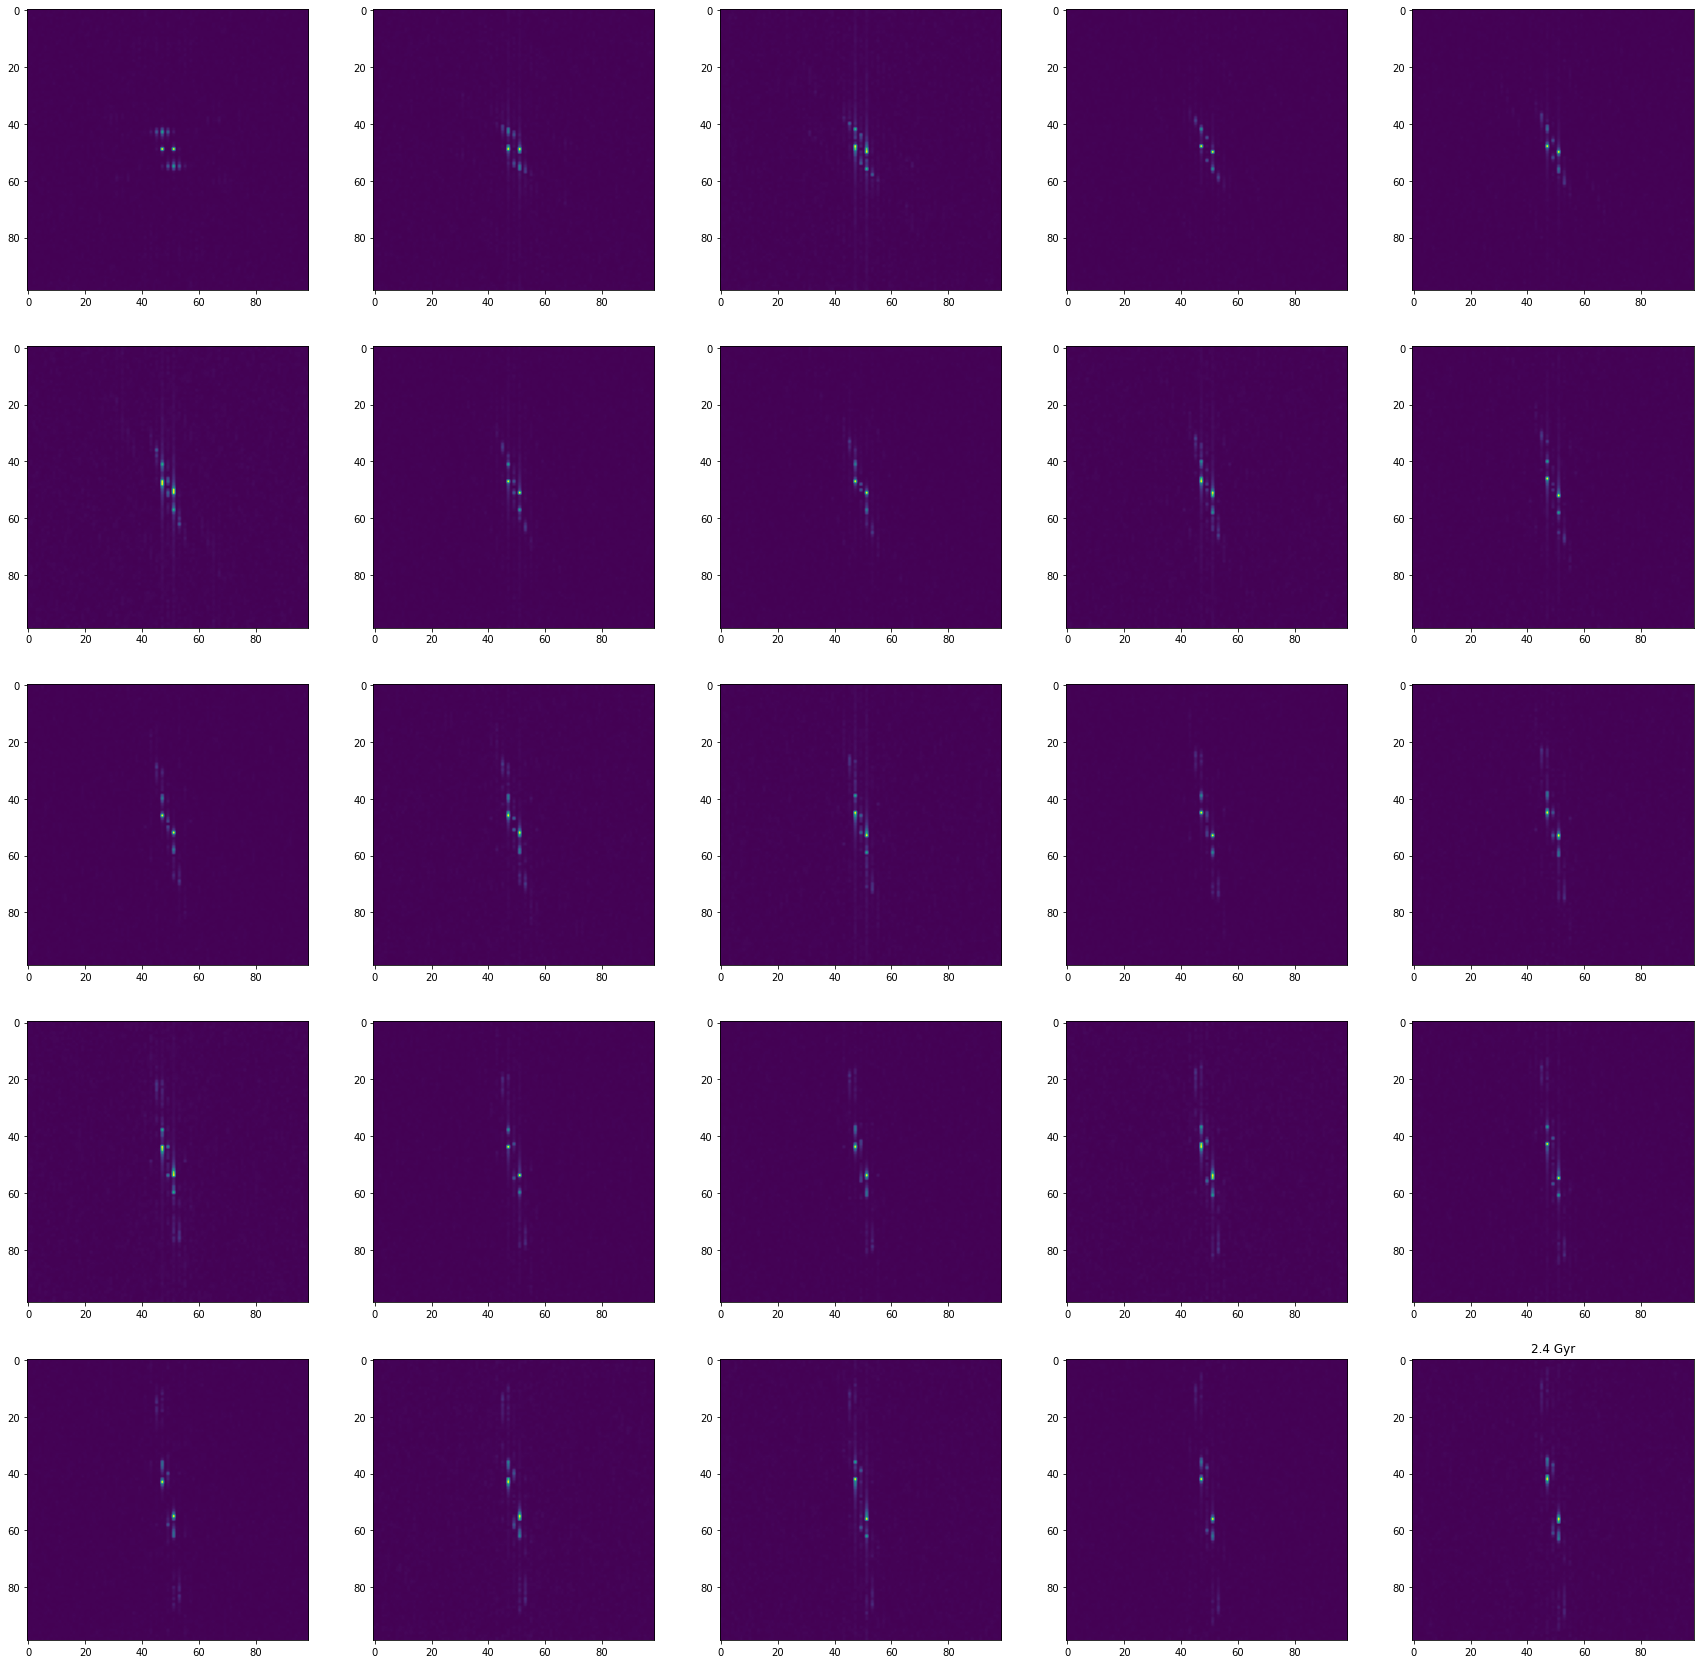

In [319]:

TIME = 1.8
BIAS = -840

def animate(frame, ax=None):
    TIME = frame * 0.1 + 0.001
    plt.title(f"{TIME:.2} Gyr")
   
    XMIN=1200
    XMAX=3500
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

    VRn = VR / Lz
    binsX=np.linspace(np.log(XMIN+BIAS),np.log(XMAX+BIAS),100)
    binsY=np.linspace(-np.pi,np.pi,100)
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(np.log(Lz+BIAS), phi, VRn, statistic='mean', bins=[binsX,binsY])    
    #plt.pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)

    mVR = np.nan_to_num(mVR)
    mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
    #plt.imshow(mVR)
    f = fftshift(fft2(ifftshift(mVR)))
    #col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
    #print(col)
    #plt.imshow(matplotlib.colors.hsv_to_rgb(col))
    if ax is None:
        return plt.imshow(abs(f))
    else:
        f[len(f)//2, len(f)//2] = np.mean(f)
        ax.imshow(abs(f))

from matplotlib.animation import FuncAnimation
import matplotlib.colors

#fig, ax = plt.subplots()
#anim = FuncAnimation(fig, animate, frames=200, interval=20)

fig, ax = plt.subplots(5,5, figsize=(30,30))
for i in range(25):
    animate(i, ax[i//5][i%5])

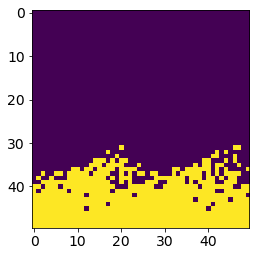

In [107]:
TIME = 0.5
t=TIME*u.Gyr
x=o.x(t)
y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
VR=o.vr(t)
Vphi=o.vphi(t)*o.r(t)
R=o.r(t)
Lz=R*Vphi
phi=o.phi(t)


binsX=np.linspace(1000,3500,50)
binsY=np.linspace(-np.pi,np.pi,50)
hist,xedge,yedge = np.histogram2d(Lz, phi, bins=50, range=[[1000,3500],[-np.pi,np.pi]])
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[binsX,binsY])    
mVR = mVR.T
#plt.pcolormesh(xedge, yedge, mVR, cmap='RdBu',vmin=-10,vmax=10)

mVR = np.nan_to_num(mVR)
plt.imshow(hist < 20)
#mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
f = fftshift(fft2(ifftshift(mVR)))
#plt.imshow(abs(f))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))

plt.show()

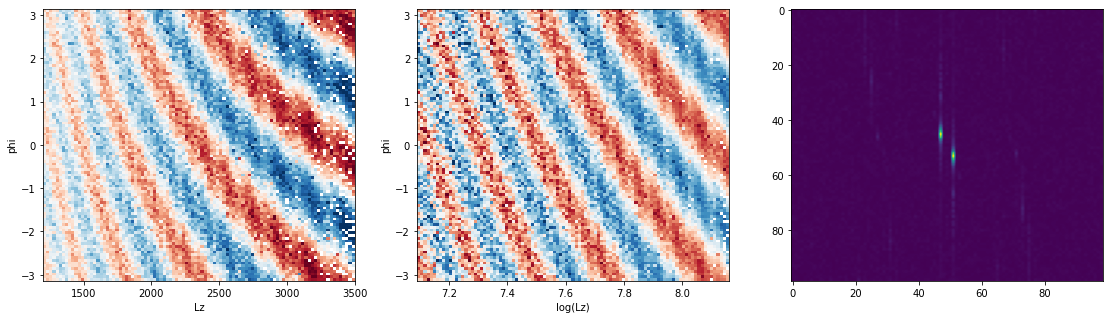

In [330]:
TIME = 1.5
BIAS = -840*0
XMIN=1200
XMAX=3500
x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
Lzl = np.log(Lz+BIAS)
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.log(XMIN+BIAS),np.log(XMAX+BIAS),100)
binsY=np.linspace(-np.pi,np.pi,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
ax[1].set_aspect('auto')
ax[1].set_xlabel('log(Lz)')
ax[1].set_ylabel('phi')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
#ax[2].imshow(abs(f))
ax[2].imshow(abs(f))
#ax[1].imshow(np.sqrt(abs(f)))
ax[2].set_aspect('auto')


In [197]:
VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
Lz=-oo['Vphi']*oo['R']
phi=-np.deg2rad(phi)
Vphi=-Vphi

PHI_RANGE = 0.2
indphi = abs(phi) < PHI_RANGE
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]

fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
BIAS = -800
Lzl = np.log(Lz+BIAS)
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.log(1500+BIAS),np.log(3000+BIAS),100)
binsY=np.linspace(-PHI_RANGE,PHI_RANGE,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1000,3000,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
ax[1].set_aspect('auto')
ax[1].set_xlabel('log(Lz)')
ax[1].set_ylabel('phi')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
ax[2].imshow(abs(f))
#ax[2].imshow(np.log(abs(f)))
ax[2].set_aspect('auto')

NameError: name 'oo' is not defined